**Building  models: ALS recommender +MobileNetV2**

**IMPPORTING LIBRARIES**

In [164]:
import numpy as np
import pandas as pd
from selenium.webdriver import Chrome
import os

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features
import os
from tqdm import tqdm
from scipy.spatial.distance import cosine
np.random.seed(0)

**LISTING HASHTAGS**

In [169]:
json_file_names = os.listdir('metadata')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['wedding', 'animals', 'travel', 'selfie', 'fitness', 'nature', 'cars', 'food']

**DATAFRAME OF HASHTAG METADATA**

In [170]:
hashtag_metadata = []
for hashtag in hashtags: 
    hashtag_metadata.append(pd.read_json(f'metadata/{hashtag}.json'))
hashtag_metadata = reduce(lambda x, y: pd.concat([x, y]), hashtag_metadata)
pd.DataFrame.reset_index(hashtag_metadata, drop=True, inplace=True)
hashtag_metadata.tail()

,post_link,image,search_hashtag,hashtags,image_local_name
35,https://www.instagram.com/p/By3PHWLF3iP/,https://scontent-lga3-1.cdninstagram.com/vp/5e...,food,[],98b4f055-0c67-4527-909d-e88c6c96bdb7.jpg
36,https://www.instagram.com/p/By3al9rB-Id/,https://scontent-lga3-1.cdninstagram.com/vp/ab...,food,"[#photooftheday, #veganfoodshare, #yum, #vegan...",3b04a00a-50ac-472d-9fdb-32690119b01e.jpg
37,https://www.instagram.com/p/By3YWNWnNDA/,https://scontent-lga3-1.cdninstagram.com/vp/80...,food,"[#bbq, #baconporn, #deliciousness, #barbecue, ...",dd243627-4d8a-4719-b097-e27b5972e20d.jpg
38,https://www.instagram.com/p/By3VXrInqMK/,https://scontent-lga3-1.cdninstagram.com/vp/32...,food,"[#mmm, #nycfood, #cheese, #eats, #yum, #hungry...",d48a33b2-a405-4533-9208-9cc85f8be024.jpg
39,https://www.instagram.com/p/By3WqqjBwG5/,https://scontent-lga3-1.cdninstagram.com/vp/0c...,food,[#vegan],bb8a20eb-ffcf-4ec1-bb88-f5203298470f.jpg


In [171]:
# Remove non-hashtags from hashtag list. 
hashtag_metadata['hashtags'] = hashtag_metadata['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

# Create a flattened list of all hashtags 
all_hashtags = [hashtag for hashtags in hashtag_metadata['hashtags'] for hashtag in hashtags]

# Coerce to a set to remove duplicate entries
# Sort to ensure reproducibility of results
all_hashtags = sorted(list(set(all_hashtags)))

# Build lookup for finding hashtag number based on hashtag name
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [172]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag_id,rating
750,38,144,1
751,38,275,1
752,38,299,1
753,38,213,1
754,39,528,1


**CREATION OF NEURAL NETWORK**

In [173]:
img_shape = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [139]:
pics = []
for i, row in tqdm(hashtag_metadata.iterrows()):
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        deep_features = extract_features(img, neural_network)
        pics.append({'pic': img, 
                     'hashtag': hashtag, 
                     'name': name,
                     'deep_features': deep_features})
    except Exception as e:
        error_type = type(e).__name__
        if error_type == "NotFoundError":
            # If a file in the list isn't in 
            # storage, skip it and continue
            pass
        else:
            print(e)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 1s/step


11it [00:01,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


12it [00:01,  7.55it/s]

1/1 [==============================] - 0s 48ms/step


13it [00:01,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


14it [00:01,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


15it [00:01,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


16it [00:02,  8.15it/s]

1/1 [==============================] - 0s 41ms/step


17it [00:02,  8.39it/s]

1/1 [==============================] - 0s 45ms/step


18it [00:02,  8.56it/s]

1/1 [==============================] - 0s 39ms/step


19it [00:02,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


20it [00:02,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


36it [00:02, 42.73it/s]

1/1 [==============================] - 0s 46ms/step


40it [00:03, 13.17it/s]


In [174]:
pics = pd.DataFrame(pics)
pics.index = pics['name']
pics.head()

,pic,hashtag,name,deep_features
name,,,,
b6316377-299c-4f5a-b17e-c7879dce5220.jpg,"(((tf.Tensor(-0.25828665, shape=(), dtype=floa...",travel,b6316377-299c-4f5a-b17e-c7879dce5220.jpg,"[0.88491607, 0.0, 0.41205043, 0.0, 0.001112508..."
5f25e1a8-ad7f-4d8b-b0b4-ca7ff3930720.jpg,"(((tf.Tensor(0.99313724, shape=(), dtype=float...",travel,5f25e1a8-ad7f-4d8b-b0b4-ca7ff3930720.jpg,"[0.31811947, 0.54041266, 0.0, 0.32017297, 0.0,..."
c0077760-c457-46f0-951a-9a1d8b941030.jpg,"(((tf.Tensor(-0.5901471, shape=(), dtype=float...",travel,c0077760-c457-46f0-951a-9a1d8b941030.jpg,"[0.704143, 0.17814547, 0.035137348, 0.0, 1.487..."
629e5c46-1c15-428f-90e7-52ce788a2d31.jpg,"(((tf.Tensor(0.9948024, shape=(), dtype=float3...",travel,629e5c46-1c15-428f-90e7-52ce788a2d31.jpg,"[0.6917125, 0.059383966, 0.0, 0.0, 0.0, 0.1459..."
812ad5ba-66d1-49ad-95c0-76ed9e8739e4.jpg,"(((tf.Tensor(0.974275, shape=(), dtype=float32...",travel,812ad5ba-66d1-49ad-95c0-76ed9e8739e4.jpg,"[0.0, 0.025793934, 0.0, 0.0, 0.069630004, 0.0,..."


**INSPECTING A PICTURE**

In [141]:
pic = pics.iloc[0] 
type(pic['pic'])

tensorflow.python.framework.ops.EagerTensor

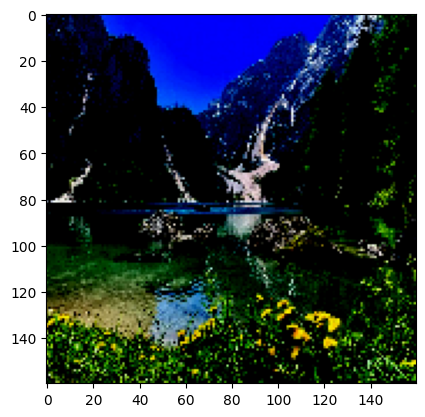

In [142]:
plt.imshow(pic['pic']);

In [143]:
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

('travel', (1280,), TensorShape([160, 160, 3]))

**ALS MODEL**

In [144]:
spark = SparkSession.builder.master('local').getOrCreate()

In [163]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

als.setSeed(0)

hashtag_spark_df = spark.createDataFrame(hashtag_rec_data)
hashtag_spark_df

DataFrame[image_id: bigint, hashtag_id: bigint, rating: bigint]

In [146]:
als_model = als.fit(hashtag_spark_df)

In [147]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag_id,rating
750,38,144,1
751,38,275,1
752,38,299,1
753,38,213,1
754,39,528,1


In [148]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
recs.tail()

,image_id,recommendations
29,18,"[(344, 1.0482161045074463), (430, 1.0187821388..."
30,19,"[(473, 1.033721923828125), (344, 0.99175113439..."
31,9,"[(40, 1.01982581615448), (426, 1.0098702907562..."
32,39,"[(528, 0.6942708492279053), (192, 0.3243898749..."
33,29,"[(391, 1.1943426132202148), (328, 1.0035294294..."


In [149]:
hashtag_index = list(all_hashtags)
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [150]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)
recs.index = recs['image_id']
recs = recs.join(hashtag_metadata, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [151]:
recs.drop('recommendations', axis=1, inplace=True)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
recs.join(image_factors);

In [152]:
# Add deep features information to recs dataframe
recs_deep = recs.join(pics, on='image_local_name', how='inner')
recs_deep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 10 to 39
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   recommended_hashtags  12 non-null     object
 1   hashtags              12 non-null     object
 2   image_local_name      12 non-null     object
 3   search_hashtag        12 non-null     object
 4   pic                   12 non-null     object
 5   hashtag               12 non-null     object
 6   name                  12 non-null     object
 7   deep_features         12 non-null     object
dtypes: object(8)
memory usage: 864.0+ bytes


In [153]:
recs.loc[0, 'image_local_name']

'cc576233-febc-4686-87d3-3c7c7690fc1c.jpg'

In [154]:
len(hashtag_lookup), type(hashtag_lookup)

(576, dict)

In [155]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#Ad,0
#AmericanMuscle,1
#AmericanMuscleCarsOfficial,2
#Arizona,3
#Car,4


In [156]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']
hashtags_df.index = hashtags_df['id']
hashtags_df.drop('id', axis=1, inplace=True)
hashtags_df.head()

,hashtag
id,
0,#Ad
1,#AmericanMuscle
2,#AmericanMuscleCarsOfficial
3,#Arizona
4,#Car


In [157]:
img_features = als_model.userFactors.toPandas()
hashtag_features = als_model.itemFactors.toPandas()

In [158]:
# Only use certain columns
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

# Add image feature into dataframe
recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

,image_local_name,hashtags,deep_features,id,features
10,b6316377-299c-4f5a-b17e-c7879dce5220.jpg,"[#lagodibraies, #mountains, #lacs, #travel, #l...","[0.88491607, 0.0, 0.41205043, 0.0, 0.001112508...",10,"[-0.0279733594506979, -0.39549556374549866, -0..."
12,c0077760-c457-46f0-951a-9a1d8b941030.jpg,"[#wanderlust, #mallorca, #balearicislands, #am...","[0.704143, 0.17814547, 0.035137348, 0.0, 1.487...",12,"[0.47688916325569153, -0.019154228270053864, -..."
13,629e5c46-1c15-428f-90e7-52ce788a2d31.jpg,"[#photooftheday, #love, #mountains, #landscape...","[0.6917125, 0.059383966, 0.0, 0.0, 0.0, 0.1459...",13,"[0.006002517882734537, -0.49218523502349854, -..."
14,812ad5ba-66d1-49ad-95c0-76ed9e8739e4.jpg,"[#worldplaces, #girlswhotravel, #kings, #nothi...","[0.0, 0.025793934, 0.0, 0.0, 0.069630004, 0.0,...",14,"[-0.06954488158226013, -0.11413266509771347, 0..."
15,5bbd926a-15ca-417a-84dc-12d203e4a46e.jpg,"[#aesthetic, #piercings, #grungeaesthetic, #so...","[0.13471894, 0.0, 0.0, 1.2039435, 0.5092525, 0...",15,"[-0.1971645951271057, -0.30008113384246826, 0...."


**TESTING THE MODEL**

In [159]:
# Function that finds k nearest neighbors by cosine similarity
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = prepare_image(image_path, where='local')
    pics = extract_features(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    return rdf.head(k)

In [160]:
def generate_hashtags(image_path):
    fnv = find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df)
    # Find the average of the 5 user features found based on cosine similarity.
    features = []
    for item in fnv.features.values:
        features.append(item)

    avg_features = np.mean(np.asarray(features), axis=0)
    
    # Add new column to the hashtag features which will be the dot product with the average image(user) features
    hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

    # Find the 10 hashtags with the highest feature dot products
    final_recs = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
    # Look up hashtags by their numeric IDs
    output = []
    for hashtag_id in final_recs.id.values:
        output.append(hashtags_df.iloc[hashtag_id]['hashtag'])
    return output

In [161]:
def show_results(test_image):
    img = mpimg.imread(f'test/{test_image}')
    plt.figure(figsize=(9, 9))
    plt.imshow(img)
    recommended_hashtags = generate_hashtags(f'test/{test_image}')
    print("RECOMMENDED HASHTAGS : \n")
    print('\n'.join(recommended_hashtags))
    print("\n")

**USER'S POINT OF VIEW**

Saving testcase3.jpg to testcase3 (3).jpg
1/1 [==============================] - 0s 67ms/step
RECOMMENDED HASHTAGS : 

#travel
#love
#landscapephotography
#landscape
#travelphotography
#nature
#travelgram
#photooftheday
#hiking
#amazing




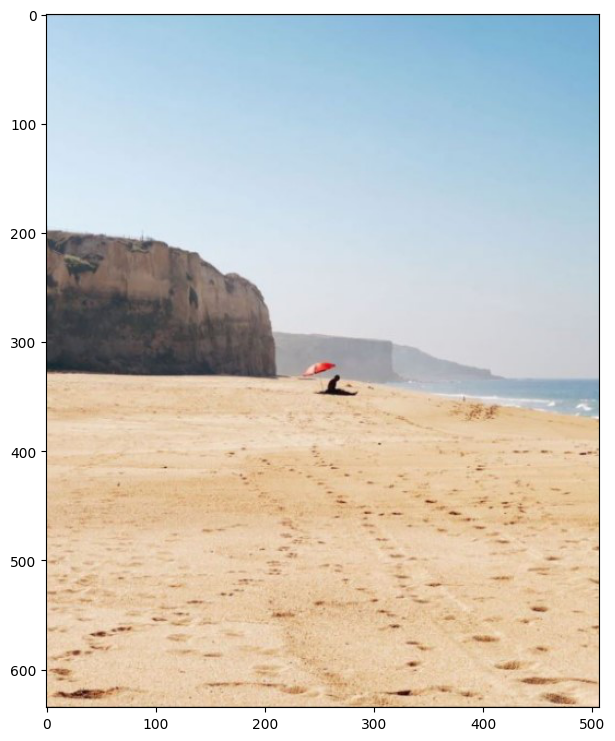

In [162]:
from google.colab import files
from PIL import Image
import os

# create the test folder if it doesn't exist
if not os.path.exists('test'):
    os.makedirs('test')

# prompt the user to upload an image
uploaded = files.upload()

# save the uploaded image to the test folder
for fn in uploaded.keys():
  with open(os.path.join('test', fn), 'wb') as f:
    f.write(uploaded[fn])

image_name=list(uploaded.keys())


show_results(image_name[0]) #passing image name 